In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import cross_val_score, KFold, learning_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
def load_and_preprocess_data():
    """加载Iris数据并进行标准化处理"""
    iris = datasets.load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = pd.Series(iris.target, name='target')
    # 回归任务：以花瓣长度为因变量
    y_reg = X['petal length (cm)']
    X_reg = X.drop('petal length (cm)', axis=1)
    # 分类任务：标准化
    scaler = StandardScaler()
    X_clf = pd.DataFrame(scaler.fit_transform(X), columns=iris.feature_names)
    return X_reg, y_reg, X_clf, y, iris

In [3]:
def regression_experiment(X, y):
    """训练三种回归模型并返回评估指标"""
    models = {
        'LinearRegression': LinearRegression(),
        'Lasso': Lasso(alpha=0.1, random_state=42),
        'Ridge': Ridge(alpha=1.0, random_state=42)
    }
    results = []
    for name, model in models.items():
        model.fit(X, y)
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        results.append({'Model': name, 'MSE': mse, 'R²': r2})
    return pd.DataFrame(results)

In [4]:
def classification_experiment(X, y):
    """12种分类模型5折交叉验证"""
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Linear SVM': SVC(kernel='linear', C=1.0, random_state=42),
        'RBF SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
        'Poly SVM': SVC(kernel='poly', degree=3, random_state=42),
        'KNN-1': KNeighborsClassifier(n_neighbors=1),
        'KNN-3': KNeighborsClassifier(n_neighbors=3),
        'KNN-5': KNeighborsClassifier(n_neighbors=5),
        'ID3': DecisionTreeClassifier(criterion='entropy', splitter='best', random_state=42),
        'C4.5': DecisionTreeClassifier(criterion='entropy', splitter='best', min_samples_split=2, random_state=42),
        'CART': DecisionTreeClassifier(criterion='gini', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
        'GBDT': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Naive Bayes': GaussianNB(),
        'ANN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
        results.append({
            'Model': name,
            'Accuracy': f"{scores.mean():.4f}±{scores.std():.4f}",
            'Mean': scores.mean(),
            'Std': scores.std()
        })
    return pd.DataFrame(results)

In [5]:
def clustering_experiment(X, y):
    """K-means聚类并计算Adjusted Rand Index"""
    results = []
    for k in [2, 3, 4]:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels_pred = kmeans.fit_predict(X)
        ari = adjusted_rand_score(y, labels_pred)
        silhouette = silhouette_score(X, labels_pred)
        results.append({'K': k, 'ARI': ari, 'Silhouette': silhouette})
    return pd.DataFrame(results)

In [6]:
def pca_visualization(X, y, iris):
    """PCA降至2维并可视化"""
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    # 可视化
    plt.figure(figsize=(10, 8))
    for target, color in zip(range(3), ['r', 'g', 'b']):
        indices = y == target
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1], 
                   c=color, label=iris.target_names[target], alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Iris PCA 2D Visualization')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('pca_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    return pca, X_pca

In [7]:
def model_interpretation(X, y):
    """随机森林特征重要性 + PCA载荷热力图"""
    # 随机森林重要性
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # PCA载荷
    pca = PCA(n_components=2, random_state=42)
    pca.fit(X)
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=X.columns
    )
    return importance, loadings

In [8]:
def plot_learning_curves(X, y):
    """绘制学习曲线分析过拟合/欠拟合"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    models = {
        'Linear SVM': SVC(kernel='linear', random_state=42),
        'RBF SVM': SVC(kernel='rbf', random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42)
    }
    for idx, (name, model) in enumerate(models.items()):
        ax = axes[idx//2, idx%2]
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, cv=5, scoring='accuracy', 
            n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
            random_state=42
        )
        ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training')
        ax.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
        ax.set_title(f'{name} Learning Curve')
        ax.legend()
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
def run_complete_experiment():
    """执行完整实验流程"""
    print("="*50)
    print("开始Iris数据集完整实验")
    print("="*50)
    
    # 1. 加载数据
    X_reg, y_reg, X_clf, y_clf, iris = load_and_preprocess_data()
    print("✓ 数据加载完成")
    
    # 2. 回归实验
    reg_results = regression_experiment(X_reg, y_reg)
    print("\n回归结果:")
    print(reg_results.to_string(index=False))
    
    # 3. 分类实验
    clf_results = classification_experiment(X_clf, y_clf)
    print("\n分类结果:")
    print(clf_results.to_string(index=False))
    
    # 4. 聚类实验
    cluster_results = clustering_experiment(X_clf, y_clf)
    print("\n聚类结果:")
    print(cluster_results.to_string(index=False))
    
    # 5. PCA可视化
    pca, X_pca = pca_visualization(X_clf, y_clf, iris)
    print(f"\n✓ PCA完成，方差贡献率: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")
    
    # 6. 模型解释
    importance, loadings = model_interpretation(X_clf, y_clf)
    print("\n特征重要性:")
    print(importance.to_string(index=False))
    
    # 7. 学习曲线
    plot_learning_curves(X_clf, y_clf)
    print("\n✓ 学习曲线已生成")
    
    # 8. 保存结果
    reg_results.to_csv('regression_results.csv', index=False)
    clf_results.to_csv('classification_results.csv', index=False)
    cluster_results.to_csv('clustering_results.csv', index=False)
    importance.to_csv('feature_importance.csv', index=False)
    loadings.to_csv('pca_loadings.csv', index=False)
    print("\n✓ 所有结果已保存至CSV文件")
    
    return {
        'regression': reg_results,
        'classification': clf_results,
        'clustering': cluster_results,
        'importance': importance,
        'loadings': loadings
    }

开始Iris数据集完整实验
✓ 数据加载完成

回归结果:
           Model      MSE       R²
LinearRegression 0.099020 0.968012
           Lasso 0.163692 0.947120
           Ridge 0.099240 0.967941

分类结果:
              Model      Accuracy     Mean      Std
Logistic Regression 0.9600±0.0249 0.960000 0.024944
         Linear SVM 0.9733±0.0133 0.973333 0.013333
            RBF SVM 0.9667±0.0211 0.966667 0.021082
           Poly SVM 0.9267±0.0327 0.926667 0.032660
              KNN-1 0.9533±0.0267 0.953333 0.026667
              KNN-3 0.9600±0.0327 0.960000 0.032660
              KNN-5 0.9600±0.0327 0.960000 0.032660
                ID3 0.9533±0.0267 0.953333 0.026667
               C4.5 0.9533±0.0267 0.953333 0.026667
               CART 0.9533±0.0267 0.953333 0.026667
      Random Forest 0.9600±0.0249 0.960000 0.024944
           AdaBoost 0.9333±0.0211 0.933333 0.021082
               GBDT 0.9533±0.0267 0.953333 0.026667
        Naive Bayes 0.9600±0.0249 0.960000 0.024944
                ANN 0.9600±0.0249 0.960000 

D:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


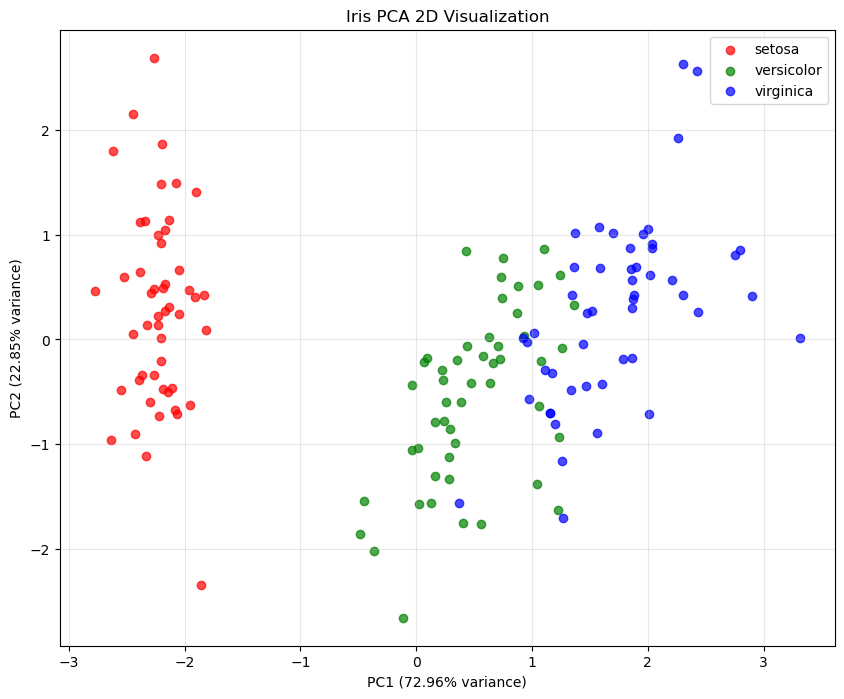


✓ PCA完成，方差贡献率: PC1=72.96%, PC2=22.85%

特征重要性:
          Feature  Importance
petal length (cm)    0.436130
 petal width (cm)    0.436065
sepal length (cm)    0.106128
 sepal width (cm)    0.021678


UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

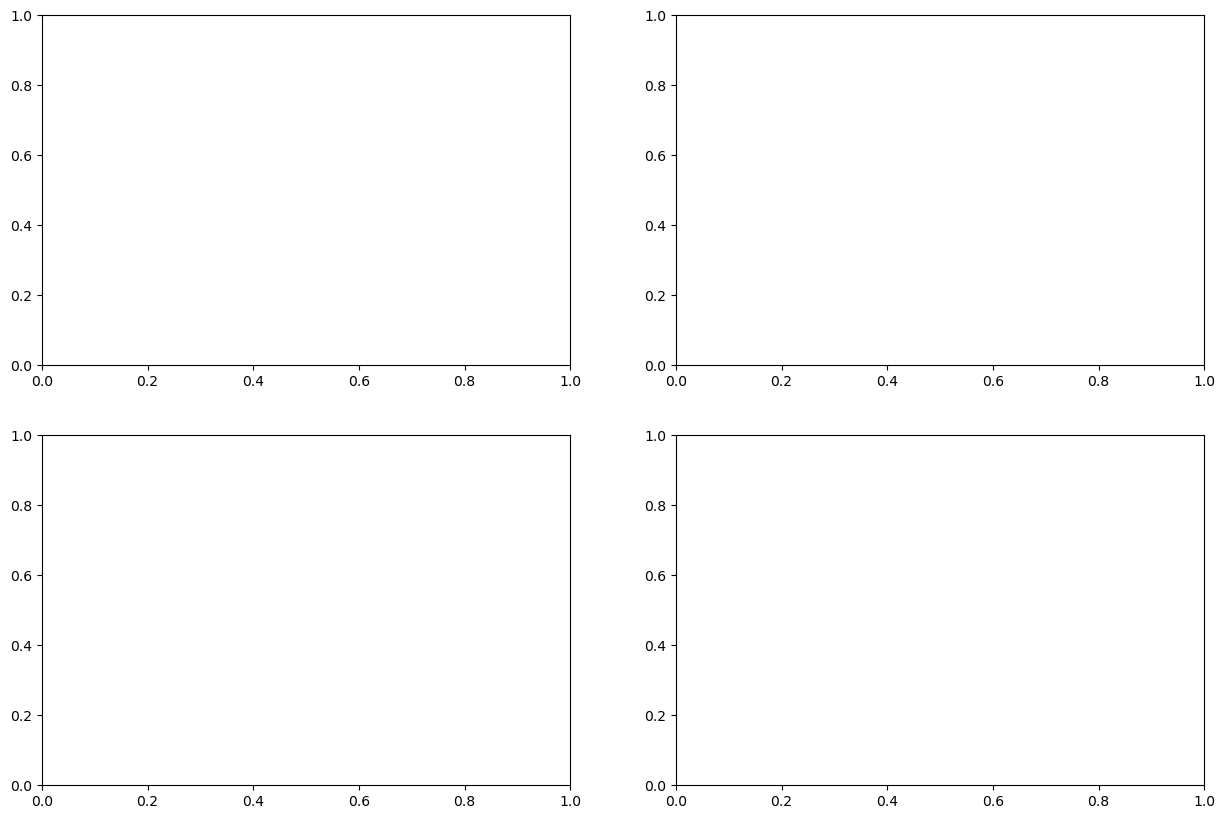

In [10]:
if __name__ == "__main__":
    # 执行完整实验
    results = run_complete_experiment()